In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.utils import plot_model

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import concatenate
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
import keras.backend as k
from keras.metrics import MeanIoU

import os
import cv2
import glob
import PIL
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  
import tensorflow as tf
# neural imaging
#import nilearn as nl
#import nibabel as nib
#import nilearn.plotting as nlplt
#import pydot
#import sys


C:\Users\21698\AppData\Roaming\Python\Python38\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
import numpy as np

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:

TRAIN_DATASET_PATH = 'Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'Data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'


In [4]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'TISSU SAIN',
    1 : 'NECROSE', # or NON-ENHANCING tumor CORE
    2 : 'OEDEME ',
    3 : 'TUMEUR REHAUSSÉE' # original 4 -> converted into 3 later
}

In [5]:
# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include



Text(0.5, 1.0, 'Masque')

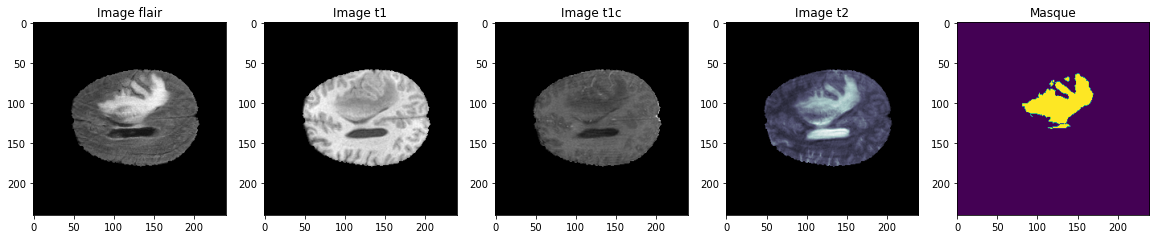

In [6]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()




fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1c')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'bone')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Masque')




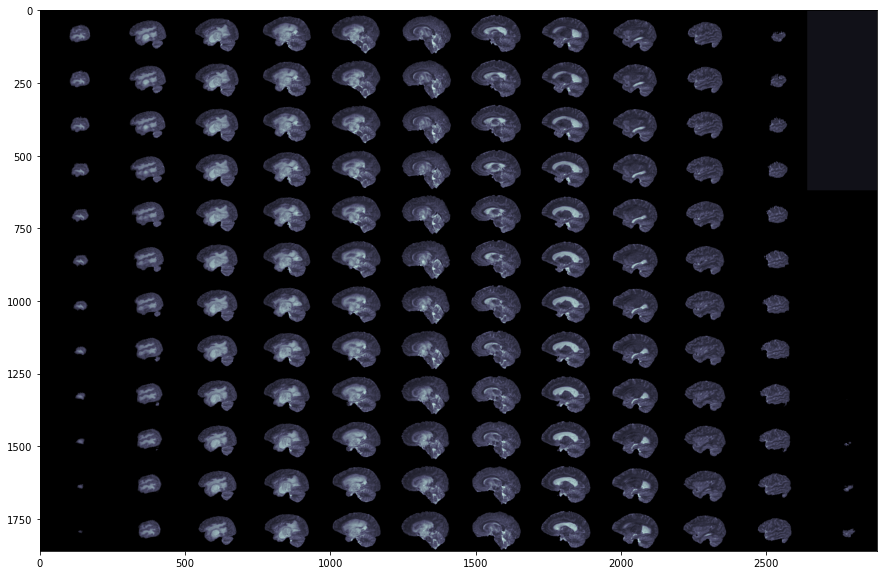

In [7]:

# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t2[50:-50,:,:]), 90, resize=True), cmap ='bone')


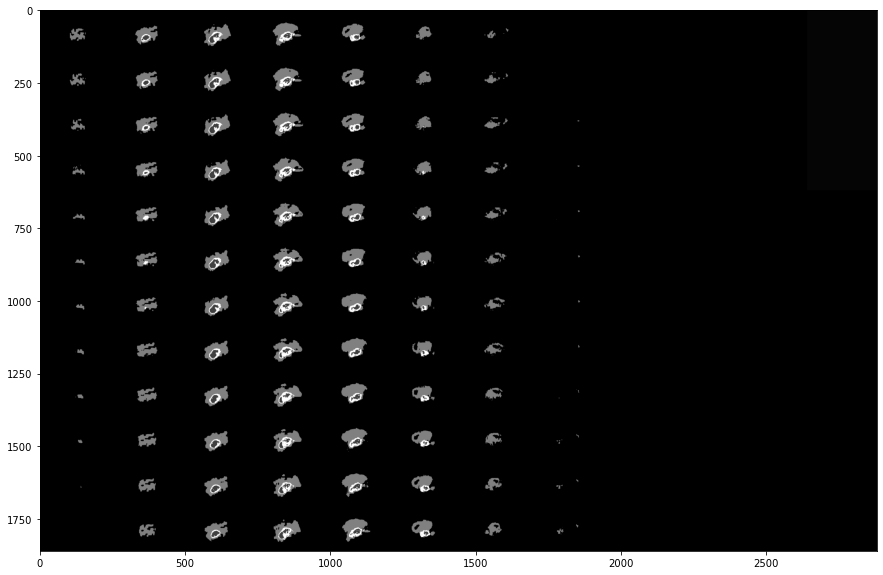

In [8]:

# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[50:-50,:,:]), 90, resize=True), cmap ='gray')



In [9]:

# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



In [10]:

 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)


def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)




In [11]:

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    # Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


In [12]:

#shutil.copy2(TRAIN_DATASET_PATH + 'BraTS20_Training_015/BraTS20_Training_015_flair.nii', './test_gif_BraTS20_Training_015_flair.nii')
#gif2nif.write_gif_normal('./test_gif_BraTS20_Training_015_flair.nii')

# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a


In [13]:

IMG_SIZE=128
inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 1))


In [14]:


def build_unet(inputs, ker_init, dropout):
    inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 1))
#    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))

  #  s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
    conv1 =  tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 =  tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool =  tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv =  tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv =  tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 =  tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 =  tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 =  tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 =  tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 =  tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 =  tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 =  tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 =  tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 =  tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 =  tf.keras.layers.Dropout(dropout)(conv5)

    up7 =  tf.keras.layers.Conv2D(256, (2, 2), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 =  tf.keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 =  tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 =  tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)
    up8 =  tf.keras.layers.Conv2D(128, (2, 2), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 =  tf.keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 =  tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 =  tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 =  tf.keras.layers.Conv2D(64, (2, 2), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 =  tf.keras.layers.concatenate([conv,up9], axis = 3)
    conv9 =  tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 =  tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up =  tf.keras.layers.Conv2D(32, (2, 2), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge =  tf.keras.layers.concatenate([conv1,up], axis = 3)
    conv =  tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv =  tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    outputs =  tf.keras.layers.Conv2D(4, (1, 1), activation = 'softmax')(conv)
    #outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

In [15]:
model = build_unet(inputs, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

 conv2d_21 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_20[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 128, 128, 4)  132         ['conv2d_21[0][0]']              
                                                                                                  
Total params: 7,759,620
Trainable params: 7,759,620
Non-trainable params: 0
__________________________________________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                  

                                )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 64  0           ['conv2d_1[0][0]',               
                                )                                 'conv2d_19[0][0]']              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 32  18464       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_20[0][0]']              
                                )                                                                 
          

In [16]:

print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 1)
(None, 128, 128, 4)


In [47]:
!pip install pydot
!pip install graphviz

In [48]:
plot_model(model, show_shapes = True, show_dtype=False, show_layer_names = True, rankdir = 'TB', expand_nested = False, dpi = 70)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:

# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]


In [19]:

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')



In [20]:

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x


In [21]:

train_and_test_ids = pathListIntoIds(train_and_val_directories); 


In [22]:

from sklearn.model_selection import train_test_split   
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 


In [23]:

class DataGenerator(keras.utils.Sequence):
    #'Generates data for Keras'
 def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
       #'Initialization'
  self.dim = dim
  self.batch_size = batch_size
  self.list_IDs = list_IDs
  self.n_channels = n_channels
  self.shuffle = shuffle
  self.on_epoch_end()

 def __len__(self):
         #'Denotes the number of batches per epoch'
     return int(np.floor(len(self.list_IDs) / self.batch_size))

 def __getitem__(self, index):
        #'Generate one batch of data'
        # Generate indexes of the batch
  indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        #Find list of IDs
  Batch_ids = [self.list_IDs[k] for k in indexes]


# Generate data
  X, y = self.__data_generation(Batch_ids)

  return X, y

 def on_epoch_end(self):
       #'Updates indexes after each epoch'
  self.indexes = np.arange(len(self.list_IDs))
  if self.shuffle == True:
   np.random.shuffle(self.indexes)

 def __data_generation(self, Batch_ids):
         # 'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
         # Initialization
  X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
  y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
  Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
  for c, i in enumerate(Batch_ids):
   case_path = os.path.join(TRAIN_DATASET_PATH, i)
   data_path = os.path.join(case_path, f'{i}_flair.nii');
   flair = nib.load(data_path).get_fdata()    
   data_path = os.path.join(case_path, f'{i}_t1ce.nii');
   ce = nib.load(data_path).get_fdata()
   data_path = os.path.join(case_path, f'{i}_seg.nii');
   seg = nib.load(data_path).get_fdata()
   for j in range(VOLUME_SLICES):
    X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
    X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
    y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
    y[y==4] = 3;
    mask = tf.one_hot(y, 4);
    Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
  return X/np.max(X), Y

In [24]:

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


In [25]:

# show number of data for each dir 
def showDataLayout():
    plt.rcParams["figure.figsize"] = (10,5)
    plt.bar(["Entraînement","Validation","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Nombre d''images')
    plt.title('Distribution des données')

    plt.show()

No handles with labels found to put in legend.


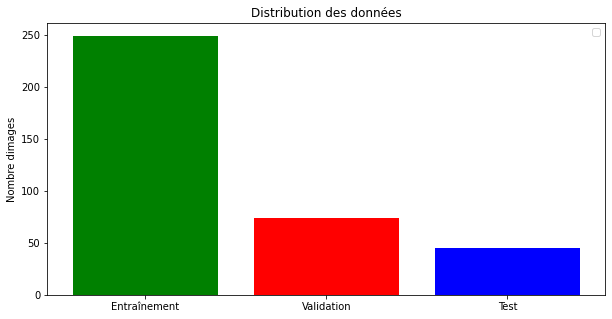

In [26]:
showDataLayout()

In [27]:

from tensorflow.keras.callbacks import CSVLogger

csv_logger = CSVLogger('training.log', separator=',', append=False)


In [28]:


callbacks = [
    keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                              patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                            verbose=1, save_best_only=True, save_weights_only = True),
     csv_logger
    ]

In [29]:

############ load trained model ################
model = keras.models.load_model('C:/Users/21698/OneDrive/Documents/GitHub/Unet-brain-tumor-segmentation/Data/saved_models/model_per_class.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)


In [30]:

history = pd.read_csv('C:/Users/21698/OneDrive/Documents/GitHub/Unet-brain-tumor-segmentation/Data/saved_models/training_per_class.log', sep=',', engine='python')

hist=history

In [31]:

acc=hist['accuracy']
val_acc=hist['val_accuracy']


In [32]:

epoch=range(len(acc))


In [33]:

loss=hist['loss']
val_loss=hist['val_loss']

In [34]:

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

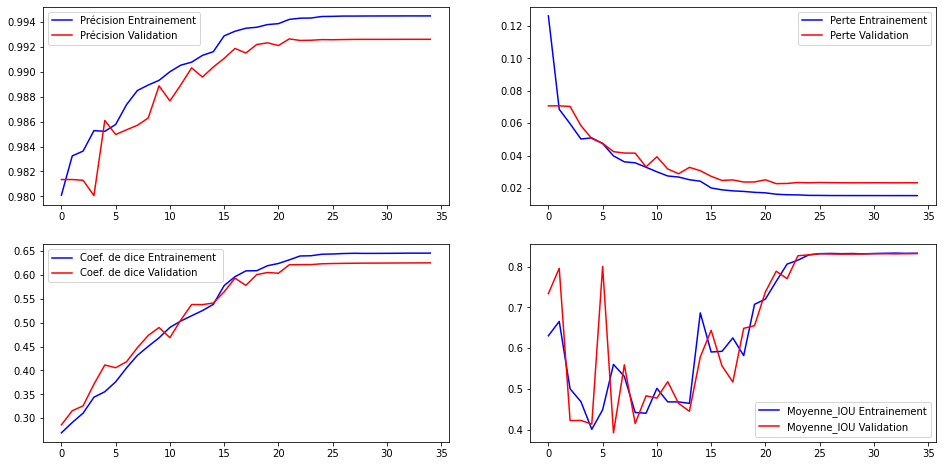

In [35]:
f,axs=plt.subplots(2,2,figsize=(16,8))
axs[0,0].plot(epoch,acc,'b',label='Précision Entrainement')
axs[0,0].plot(epoch,val_acc,'r',label='Précision Validation')
axs[0,0].legend()
#axs[0,1].legend()
axs[0,1].plot(epoch,loss,'b',label='Perte Entrainement')
axs[0,1].plot(epoch,val_loss,'r',label='Perte Validation')
axs[0,1].legend()
#axs[1,1].legend()
axs[1,0].plot(epoch,train_dice,'b',label='Coef. de dice Entrainement ')
axs[1,0].plot(epoch,val_dice,'r',label='Coef. de dice Validation')
axs[1,0].legend()

axs[1,1].plot(epoch,hist['mean_io_u'],'b',label='Moyenne_IOU Entrainement')
axs[1,1].plot(epoch,hist['val_mean_io_u'],'r',label='Moyenne_IOU Validation')
axs[1,1].legend()

plt.show()

In [36]:

# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)



In [37]:

# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
    for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        

In [38]:
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)


In [39]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
    seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)



4/4 [==============================] - 3s 667ms/step


<Figure size 1296x3600 with 0 Axes>

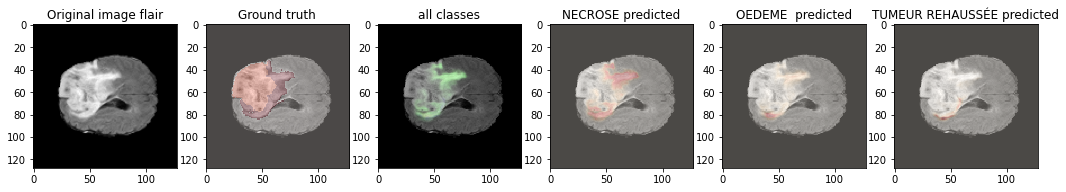

4/4 [==============================] - 3s 661ms/step


<Figure size 1296x3600 with 0 Axes>

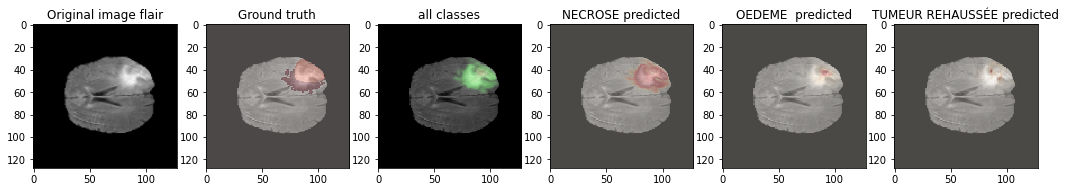

4/4 [==============================] - 3s 681ms/step


<Figure size 1296x3600 with 0 Axes>

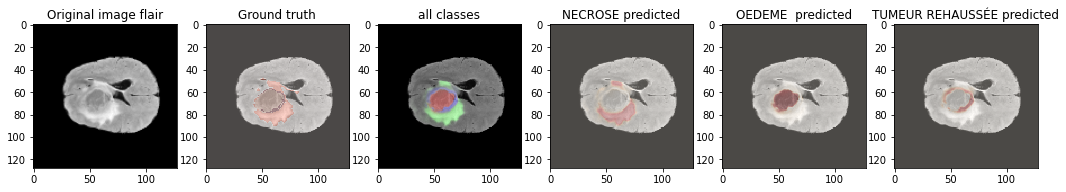

4/4 [==============================] - 3s 671ms/step


<Figure size 1296x3600 with 0 Axes>

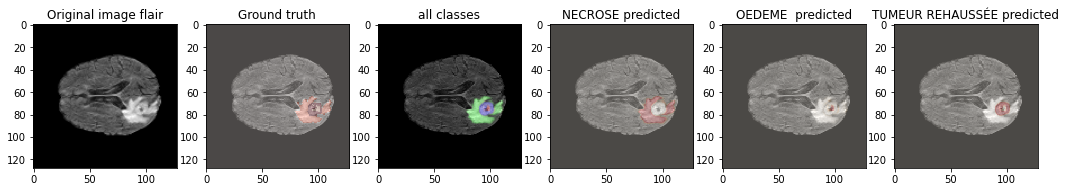

4/4 [==============================] - 3s 683ms/step


<Figure size 1296x3600 with 0 Axes>

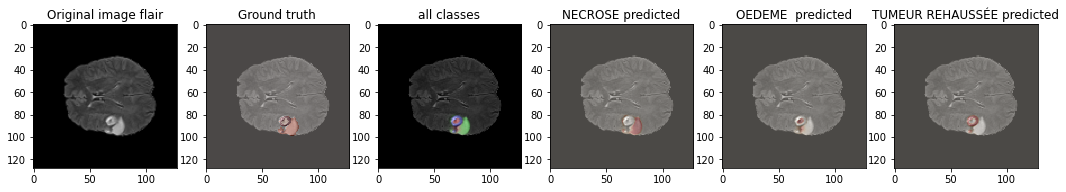

4/4 [==============================] - 3s 663ms/step


<Figure size 1296x3600 with 0 Axes>

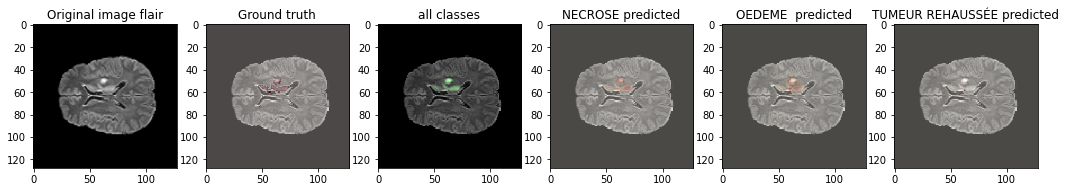

4/4 [==============================] - 4s 928ms/step


<Figure size 1296x3600 with 0 Axes>

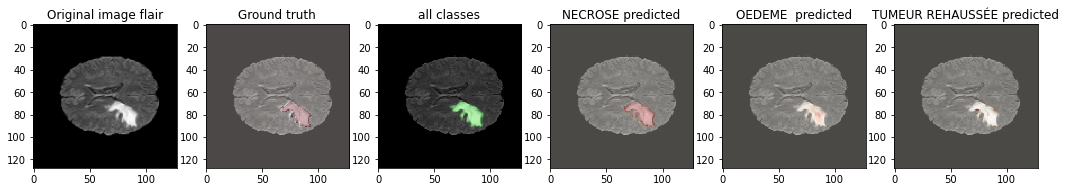

In [40]:

def showPredictsById(case, start_slice = 60):
    path = f"Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
       
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])

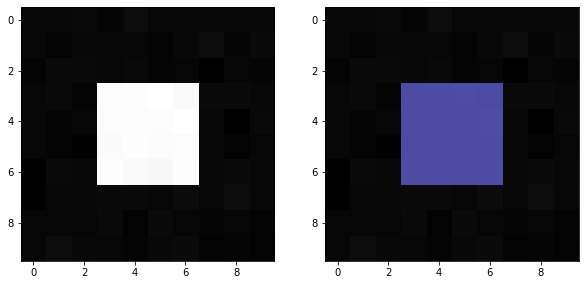

In [41]:
mask = np.zeros((10,10))
mask[3:-3, 3:-3] = 1 # white square in black background
im = mask + np.random.randn(10,10) * 0.01 # random image
masked = np.ma.masked_where(mask == 0, mask)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im, 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(im, 'gray', interpolation='none')
plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
plt.show()


In [42]:

case = case=test_ids[3][-3:]
path = f"Data//BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)



4/4 [==============================] - 5s 1s/step


In [43]:

core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]



In [44]:

i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'


<Figure size 720x360 with 0 Axes>

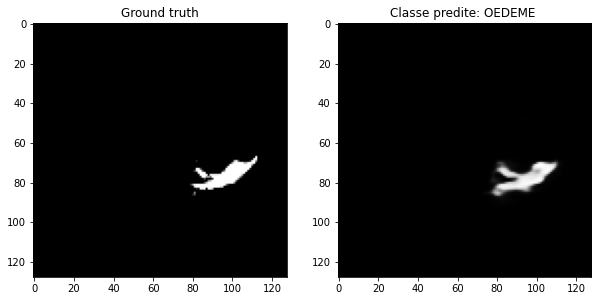

In [45]:
gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'Classe predite: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [46]:
#model.compile(loss="categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
#print("Evaluate on test data")
#results = model.evaluate(test_generator, batch_size=256, callbacks= callbacks)
#print("test loss, test acc:", results)



Evaluate on test data


NameError: in user code:

    File "C:\Users\21698\anaconda3\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "<ipython-input-9-0dbe760bff76>", line 5, in dice_coef  *
        y_true_f = K.flatten(y_true[:,:,:,i])

    NameError: name 'K' is not defined
